In [ ]:
# The Julia boostrap block
# This should be run for the first time to install Julia kernel, and then refresh this page (e.g., Ctrl-R)
# so that colab will redirect to the installed Julia kernel
# and then doing your own work

# 1. install latest Julia using jill.py
#    tip: one can install specific Julia version using e.g., `jill install 1.7`
!pip install jill && jill install --upstream Official --confirm
# 2. install IJulia kernel
! julia -e 'using Pkg; pkg"add IJulia, PyPlot, Printf"; using IJulia; installkernel("Julia")'
# 3. hot-fix patch to strip the version suffix of the installed kernel so that this notebook kernelspec is version agnostic
!jupyter kernelspec install $(jupyter kernelspec list | grep julia | tr -s ' ' | cut -d' ' -f3) --replace --name julia

In [10]:
using PyPlot, Printf

# ∂ₜu + a∂ₓu = c∂ₓₓu
# wrap our Problem into some struct
struct Equation
    c::Float64
    a::Float64
    u0::Function
    T::Float64
end

struct Discretization
    dx::Float64
    dt::Float64
end

struct Problem
    eq::Equation
    dx::Float64
    dt::Float64
    N::Int64
    Nt::Int64
    x::Vector
    u0::Vector
end

struct Result
    prob::Problem
    sol::Matrix
end

function Problem(eq::Equation, discret::Discretization)
    dx, dt = discret.dx,discret.dt
    N = floor(Int, 1/dx)
    Nt = floor(Int, eq.T/dt)+1
    x = Vector(0:discret.dx:(N-1)*discret.dx)
    u0 = map(eq.u0, x)
    return Problem(eq,dx,dt,N,Nt,x,u0)
end

# write the conditions you want to check here
function check_conditions(p::Problem)
    a, c = p.eq.a, p.eq.c
    dx, dt = p.dx, p.dt
    @show a, c, dx, dt
    
    return
end

# plot result
function plot_result(r::Result)
    plot(r.prob.x, r.sol[:,1], label="t=0")
    for ti in [floor(Int, r.prob.Nt*i) for i in [0.2,0.4,0.6,0.8]]
        plot(r.prob.x, r.sol[:,ti], label=@sprintf("t=%.3f",r.prob.dt*(ti-1)))
    end
    plot(r.prob.x, r.sol[:,end], label="t=$(r.prob.dt*(r.prob.Nt-1))")
    legend()
    show()
end


plot_result (generic function with 1 method)

In [11]:
# zero value boundary
handleleft(u,i) = (i==1) ? 0 : u[i-1]
handleright(u,i) = (i==length(u)) ? 0 : u[i+1]

function update!(u::Vector, un::Vector, p::Problem, ::Val{:upwind})
    for i in 1:length(u)
        u[i] = un[i] - p.dt*(
                max(p.eq.a,0)*(un[i]-handleleft(un,i))/p.dx + 
                min(p.eq.a,0)*(handleright(un,i)-un[i])/p.dx - 
                p.eq.c*(handleleft(un,i) - 2un[i] + handleright(un,i))/(p.dx^2))
    end
    return
end

function update!(u::Vector, un::Vector, p::Problem, ::Val{:central})
    for i in 1:length(u)
        u[i] = un[i] - p.dt*(
                p.eq.a*(handleright(un,i)-handleleft(un,i))/(2*p.dx) - 
                p.eq.c*(handleleft(un,i) - 2un[i] + handleright(un,i))/(p.dx^2))
    end
    return
end

function solve_explicit(p::Problem, method)
    check_conditions(p)
    sol = zeros(p.N, p.Nt)
    sol[:,1] = copy(p.u0)

    u_next = zeros(p.N)
    u = copy(p.u0)

    for ti in 2:p.Nt
        update!(u_next, u, p, Val(method))
        u = copy(u_next)
        sol[:,ti] = u_next
    end
    return Result(p, sol)
end

solve_explicit (generic function with 1 method)

(a, c, dx, dt) = (1.0, 0.01, 0.01, 0.0003)


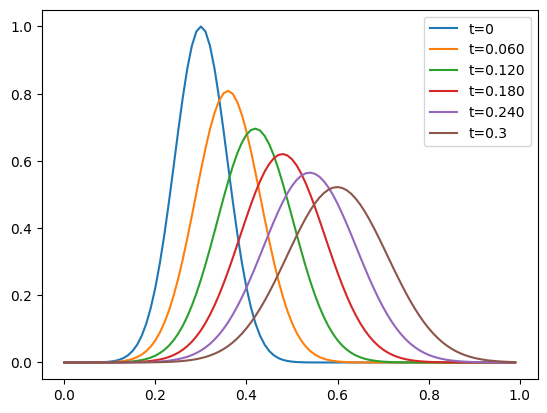

In [12]:
begin
    dx = 0.01
    dt = 0.0003
    discret = Discretization(dx, dt)

    c = 0.01
    a = 1
    T = 0.3
    u0(x) = exp(-150*(x-0.3)^2)
    eq = Equation(c, a, u0, T)

    prob = Problem(eq, discret)
    sol = solve_explicit(prob, :upwind)
    return 
end

plot_result(sol)

(a, c, dx, dt) = (0.01, 0.05, 0.01, 0.001)


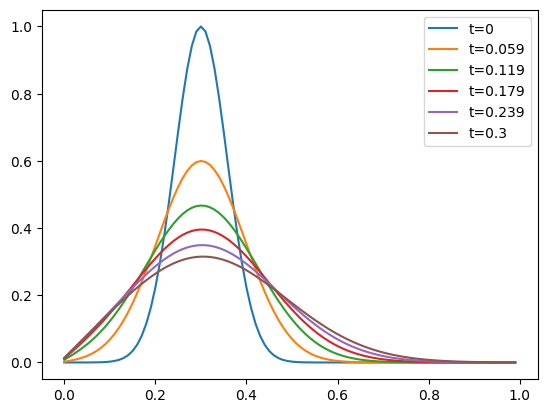

In [13]:
begin
    dx = 0.01
    dt = 0.001
    discret = Discretization(dx, dt)

    c = 0.05
    a = 0.01
    T = 0.3
    u0(x) = exp(-150*(x-0.3)^2)
    eq = Equation(c, a, u0, T)

    prob = Problem(eq, discret)
    sol = solve_explicit(prob, :central)
    return
end

plot_result(sol)
